# Setup

## Colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

path = '/Polimi/S12/Natural Language Processing/Project'

os.chdir(f'/content/drive/MyDrive/{path}')

Mounted at /content/drive


## Imports

In [ ]:
import re
import pandas as pd
import nltk
import time
import matplotlib.pyplot as plt
import random

!pip install -q emoji-regex # A regex for filtering emoji
import emoji_regex

!pip install langid
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=5fee3b25b7f31a8fe4c90089ba808a48267489749b3bb9b8e1aff1fd2c4d900f
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Globals

In [ ]:
emo_regex = emoji_regex.emoji_regex.pattern # Example: 🔥
username_regex = r'u\/\w*' # Example: u/ilovenlp
subreddit_regex = r'r\/\w*' # Example: r/welovenlp
url_regex = r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)' # Example: http://reddit.com
emoticon_regex = r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)' # Example: :)
special_chars_regex = r'\t|\n|\r|\f|\v'
special_chars_regex_2 = r'[$&+:_;=?@#\'\"<>\]\[|\\,.^*)(…%!\}\{]'
numbers_regex = r'\d+'
img_regex = r'\w*imgemo\w*' # Example: imgemotetth

final_regex = emo_regex + '|' + username_regex + '|' + subreddit_regex + '|' + url_regex + '|' + emoticon_regex + '|' + special_chars_regex + '|' + special_chars_regex_2 + '|' + numbers_regex

#Note: we could maybe keep emoji and emoticon for sentiment analysis, and maybe numbers

#Original dataset

Here is a look at one of the parquet files that compose the dataset, which (hopefully) is a representative subset of the whole reddit dataset.

## Loading data

In [ ]:
df = pd.read_parquet('./train-DataEntity_chunk_0.parquet')

In [ ]:
df

,text,label,dataType,communityName,datetime,username_encoded,url_encoded
0,While they all unconditionally idolize Kuze\n....,r/tokidokibosottoroshia,post,r/TokidokiBosottoRoshia,2025-02-12,Z0FBQUFBQm5zbVU3VWV3RFN4VUxlbVNTdnZWWlRPaERleG...,Z0FBQUFBQm5zbVdIRlZpb3hyMXdBUDl0ZmRNTGt2cDUwS0...
1,\n\nhttps://i.redd.it/jgjcttm18pie1.gif\n\nTo ...,r/zenlesszonezero,post,r/ZenlessZoneZero,2025-02-12,Z0FBQUFBQm5zbVU3bEI0LVducnlNRjZJaWFHeGJnclJMdD...,Z0FBQUFBQm5zbVdISktxaWFPTlZsNV9QRktwMXZTanVsNX...
2,"If your Fluff/Meme post uses Non-OC art, pleas...",r/zenlesszonezero,comment,r/ZenlessZoneZero,2025-02-12,Z0FBQUFBQm5zbVU3ODJ1aGF2dFVlcTU3SW1vVTktY014RD...,Z0FBQUFBQm5zbVdIVm5TNFVhYTBXM196U2w0WTRlUzBoaX...
3,They will be happy even if you eat like an ani...,r/memes,comment,r/memes,2025-02-12,Z0FBQUFBQm5zbVU3UG1vQ3NJWGI0VzQ0SS1iUzVZNXBURW...,Z0FBQUFBQm5zbVdISVFlOTNqUmNtN2tMY3c2SG15Q0pCY0...
4,https://preview.redd.it/c72wy3kg8pie1.png?widt...,r/tokidokibosottoroshia,comment,r/TokidokiBosottoRoshia,2025-02-12,Z0FBQUFBQm5zbVU3dWNCS09xbENNbmQyOXZnVF9QMURBX2...,Z0FBQUFBQm5zbVdIWG0wR1hocVNENmZiVFhRd1ZFdnUta1...
...,...,...,...,...,...,...,...
986268,The arguments against big tech are theoretical...,r/signal,comment,r/signal,2025-02-15,Z0FBQUFBQm5zbVdIZ0JxTG1kVEZKTlp4Nkt0Sl9WSzlTN1...,Z0FBQUFBQm5zbVhVVzlCWFZpR2JxUVpEQUdfa1hvTzFzUX...
986269,Maybe once a week,r/askreddit,comment,r/AskReddit,2025-02-15,Z0FBQUFBQm5zbVdIME5aNnJreUVhVExqYmNLal9jV1BQdE...,Z0FBQUFBQm5zbVhVWGNyOHlEYTlEZEZRYnA3Rm12azI5a0...
986270,What is a full coiner?,r/bitcoin,comment,r/Bitcoin,2025-02-15,Z0FBQUFBQm5zbVdIOVkwX2U3b2FsWDBPalIwLVVtbWoxNV...,Z0FBQUFBQm5zbVhVTTU5dGtTYmctaHU2SFhDeGZGNjhmNj...
986271,You nailed it on the head. They are very good ...,r/genshin_impact,comment,r/Genshin_Impact,2025-02-15,Z0FBQUFBQm5zbVdIQ0d6eWczNUNPM0QwSzBUQlZIVUFPWW...,Z0FBQUFBQm5zbVhVVzUydVh3Vjltd05qR1RMaGNrU2VxUW...


## Distribution analysis

The dataset is an exhaustive copy of reddit posts and comments gathered between January 29th 2025 and April 23rd 2025, with their associated subreddit (rarely user page) and publication date. The username and url can also be found in an encoded format, but they are of little interest for our analyses.

As a systematic copy of reddit content, the dataset was not curated at all*, and in particular not formatted for any specific task, though the subreddit labels encourage doing some kind of classification. By definition, comments are human reactions to posts, and as such could be used for sentiment analysis once labelled. Lastly, many questions and answers can be found in the dataset, so some question answering/semantic search model could be trained.


*While some very... tasteless stuff can be found in the above subset, it seems the author of the dataset filtered out 18+ subreddits.

In [ ]:
df = df[["text", "label", "dataType", "communityName", "datetime"]]
df.describe()

,text,label,dataType,communityName,datetime
count,986273,986273,986273,986273,986273
unique,934173,26022,2,26022,4
top,[removed],r/politics,comment,r/politics,2025-02-13
freq,3054,11168,883535,11168,412207


Unsurprisingly, r/politics is the most active subreddit in our dataset.

The average length of text objects (in total characters) is:

In [ ]:
print(df.text.str.len().mean())

271.48538791997754


Let's have a look at the distributions of objects across the 100 most active subreddits:

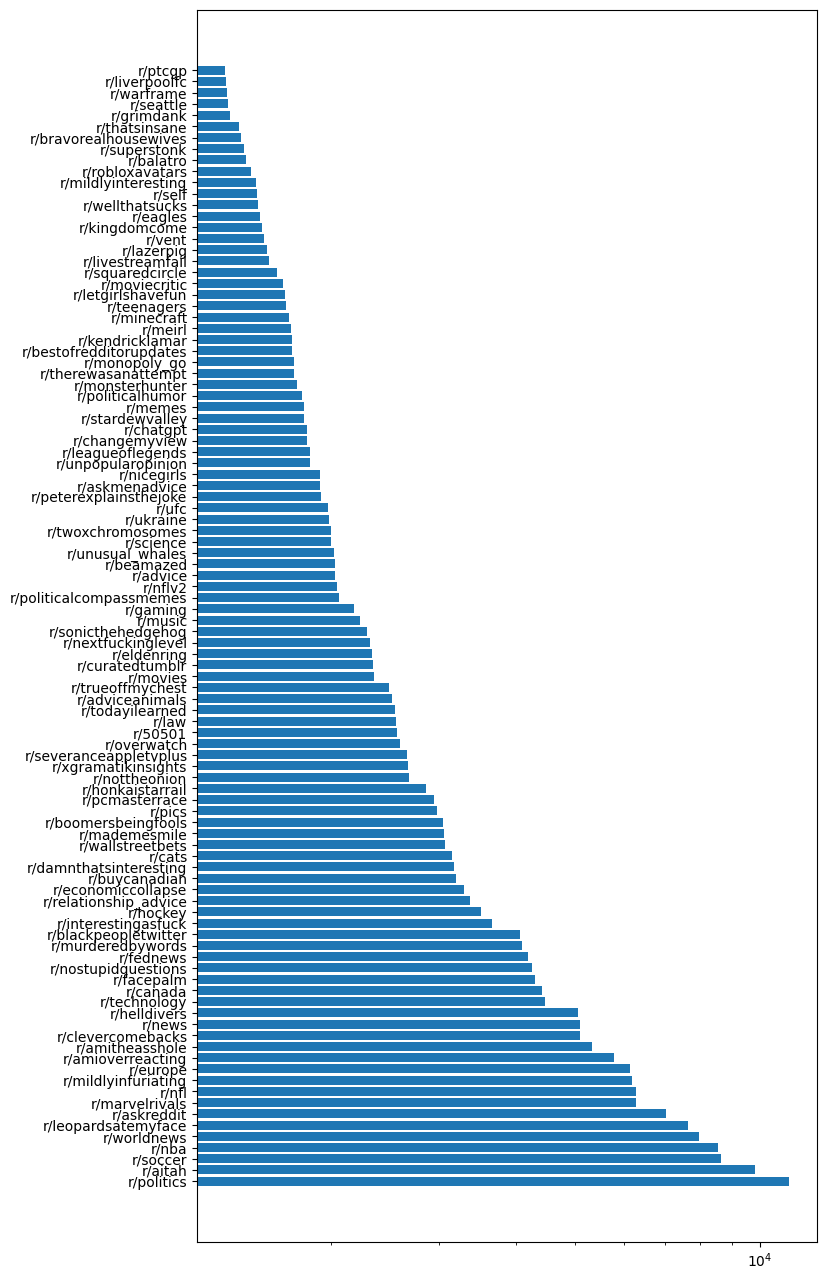

In [ ]:
label_count = dict(df.label.value_counts()[:100])
plt.figure(figsize=(8, 16))
plt.barh(range(len(label_count)), label_count.values())
plt.yticks(range(len(label_count)), label_count.keys())
plt.xscale('log')
plt.show()

The length of text objects (in total characters) follows the following distribution:

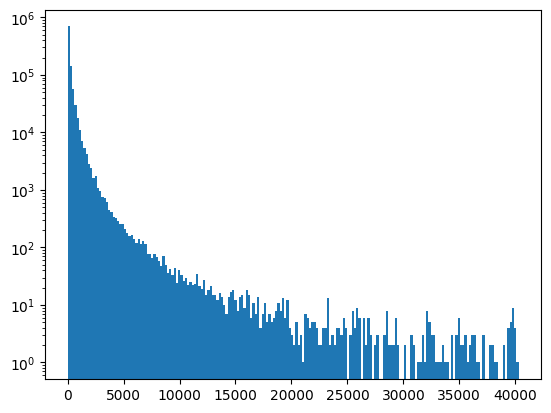

In [ ]:
plt.hist(df.text.str.len(), bins=200, log=True)
plt.show()

The average length of text objects (in space-separated words) is:

In [ ]:
print(df.text.str.split().apply(len).mean())

46.797566191105304


The length of text objects (in space-separated words) follows the following distribution:

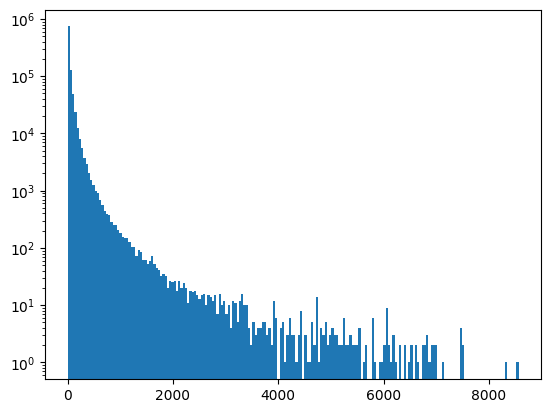

In [ ]:
plt.hist(df.text.str.split().apply(len), bins=200, log=True)
plt.show()

Now let's see which subreddits have the longest messages on average in terms of characters:

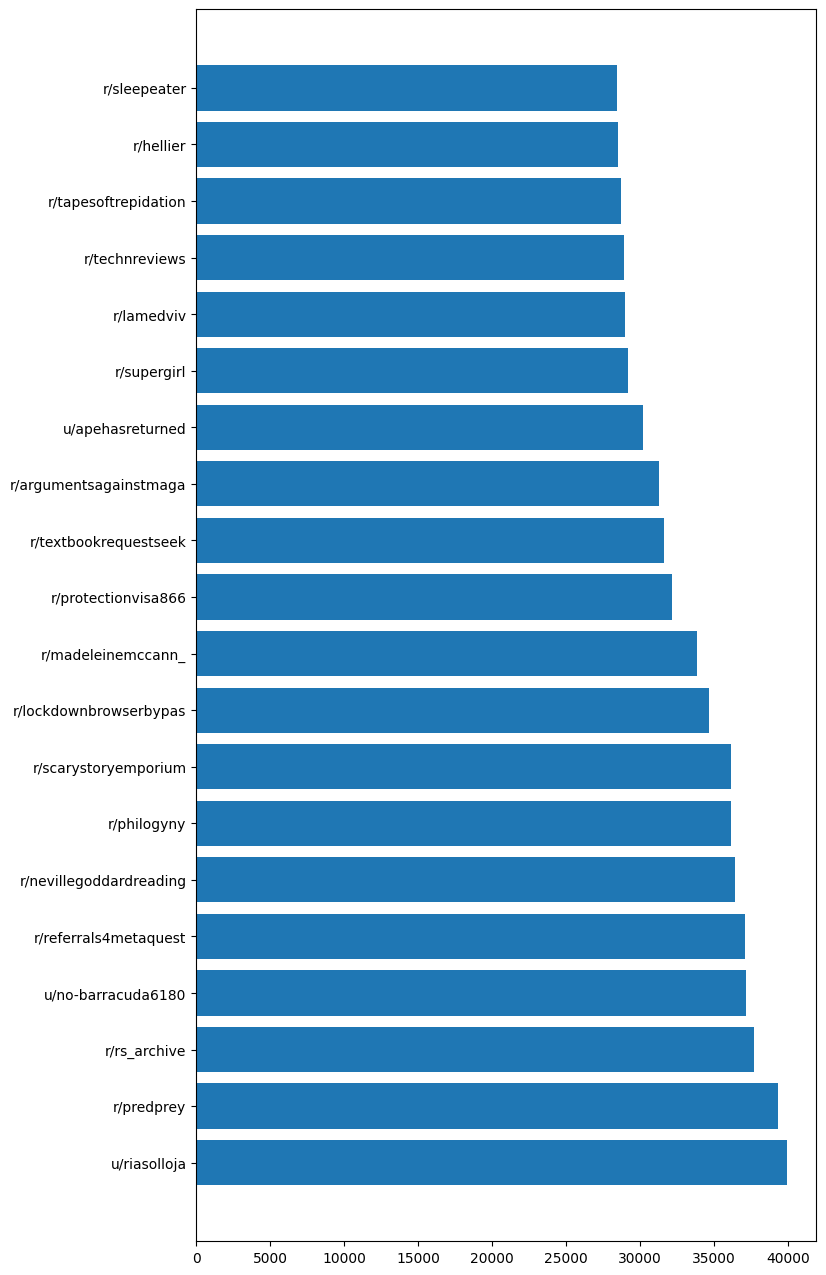

In [ ]:
avg_len_by_subreddit = df.groupby('label').text.apply(lambda x: x.str.len().mean())
avg_len_by_subreddit = avg_len_by_subreddit.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 16))
plt.barh(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.values)
plt.yticks(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.keys())
plt.show()

And in terms of words:

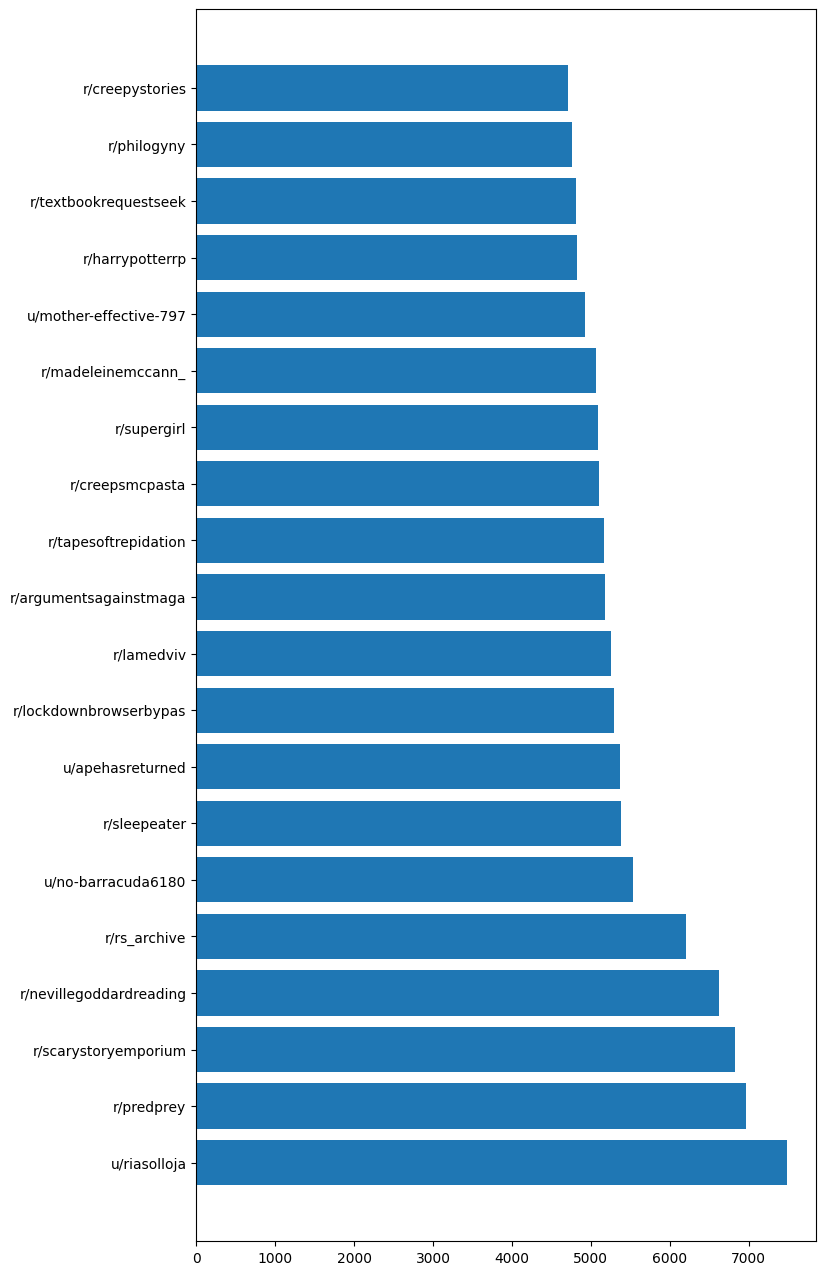

In [ ]:
avg_len_by_subreddit = df.groupby('label').text.apply(lambda x: x.str.split().apply(len).mean())
avg_len_by_subreddit = avg_len_by_subreddit.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 16))
plt.barh(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.values)
plt.yticks(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.keys())
plt.show()

That's... not really interesting, mostly obscure pages that have (or had at the time the dataset was created) only a few very long text objects.

The same analysis but on shortest objects is not of much more interest.

One last thing we can do is check the posts-to-comments ratios.

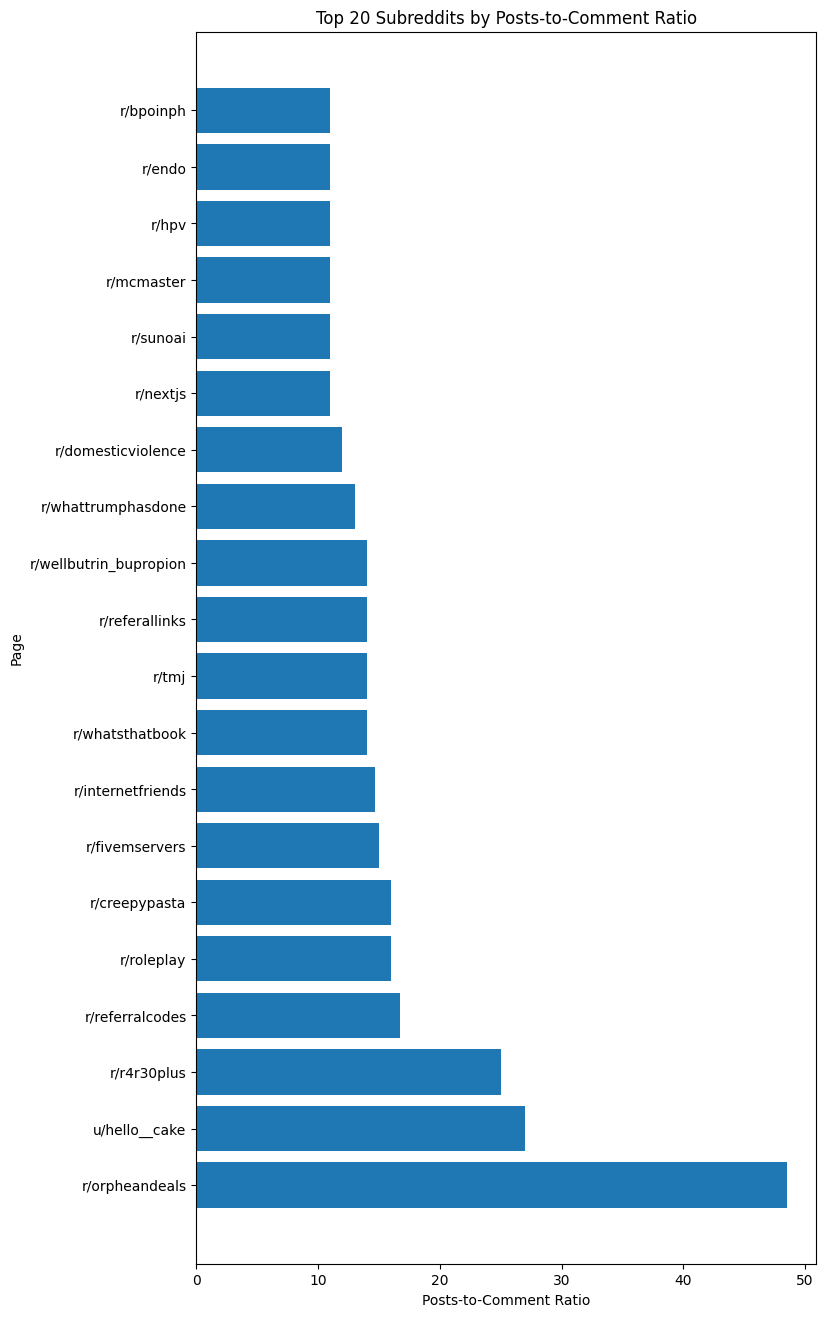

In [ ]:
posts_comments_ratio = df.groupby('label').dataType.value_counts(normalize=True)
posts_comments_ratio = posts_comments_ratio.unstack()
posts_comments_ratio = posts_comments_ratio['post'] / posts_comments_ratio['comment']
posts_comments_ratio = posts_comments_ratio.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 16))
plt.barh(range(len(posts_comments_ratio)), posts_comments_ratio.values)
plt.yticks(range(len(posts_comments_ratio)), posts_comments_ratio.keys())
plt.xlabel("Posts-to-Comment Ratio")
plt.ylabel("Page")
plt.title("Top 20 Subreddits by Posts-to-Comment Ratio")
plt.show()

Funnily enough, the top contender here was banned for spam. These are communities where people post a lot but do not comment that much. Further investigations woudl certainly reveal that these as full of spam, or subreddits where people do not not tend react much to the posts.

Now the opposite:

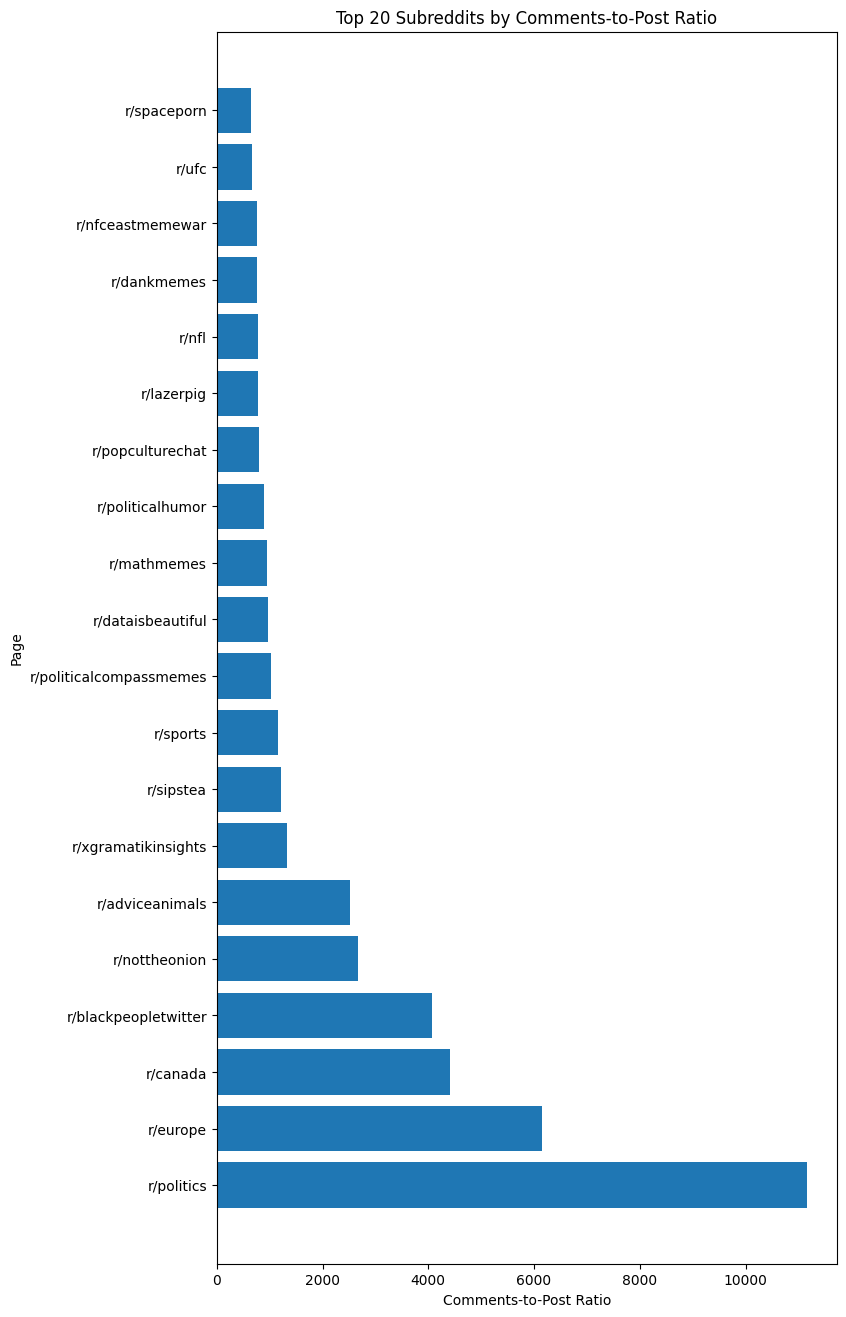

In [ ]:
comments_posts_ratio = df.groupby('label').dataType.value_counts(normalize=True)
comments_posts_ratio = comments_posts_ratio.unstack()
comments_posts_ratio = comments_posts_ratio['comment'] / comments_posts_ratio['post']
comments_posts_ratio = comments_posts_ratio.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 16))
plt.barh(range(len(comments_posts_ratio)), comments_posts_ratio.values)
plt.yticks(range(len(comments_posts_ratio)), comments_posts_ratio.keys())
plt.xlabel("Comments-to-Post Ratio")
plt.ylabel("Page")
plt.title("Top 20 Subreddits by Comments-to-Post Ratio")
plt.show()

Here are pages where people tend to react a lot to the posts. Unsurprinsingly, there are many political, sports, and news-oriented communities here, where people are prone to engage in debates in the comments.

## Vocabulary analysis

In [ ]:
corpus = list(df.text)
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

CountVectorizer()

The total length of the vocabulary is:

In [ ]:
vocab_length = len(vectorizer.get_feature_names_out())
vocab_length

474879

And on average per document:

In [ ]:
vector_documents = vectorizer.transform(corpus)
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]
nonzero_count/doc_count

31.31004600146207

Let's have a look at some examples:

In [ ]:
samples = random.sample(list(vectorizer.get_feature_names_out()), 300)
print(samples)

['nachosaurus', 'glossier', 'moreishness', 'huite', 'pallini', 'ankihub', 'spbny9tvxsy', 'jurídicos', 'steamstatic', 'invt', 'leslie', 'onuphry', 'jose', 'misinformative', 'littlekidlover', '2x6', 'ohb', 'rejse', 'exacerbations', 'dunsterhouse', 'tkz', 'xeons', 'ry', 'ppha', 'theil', 'potinage', 'weigher', 'blheli', 'n2s1o3', 'magpapasurgery', 'enes', 'ageism', 'cajuste', 'tukso', 'katarina', '20breaker', 'ycombinator', 'runedsceptre', 'sanguivorian', 'oya', 'okonma', 'patroll', '6x', '781469edff341e9c74249008f411781b3363e115', 'creepypastry', 'rationalism', 'kağnımobile', 'pish', 'succumbs', 'vastgesteld', 'divertissements', 'renegotiated', '05ff7c28ce8f51f3c794373937c5564d00a36f59', 'godhan', 'deathfight', 'ozvbxtt1pcje1', 'merisi', 'woooooahhhh', 'sectarian_bias', '63615b3799a9', 'd0qmf1k8zaeowqlzywviycz6qndk8a59mpnhefzfp0evgfnitagiv7_gpxg_xc3s2zzvetg628f9v', 'nonuser', 'criar', 'tv4', 'csajról', '2po1mr0n1cje1', 'vitner', 'syh', 'trull', 'presidence', 'btch', 'vnplymx9hpie1', 'made

As expected, there are typos, nonsense, non-English words and so on that we need to filter out. Let's only consider terms that appear in at least 20 documents, hopefully removing most garbage.

In [ ]:
vectorizer = CountVectorizer(min_df=20)
vectorizer.fit(corpus)
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
samples = random.sample(list(vectorizer.get_feature_names_out()), 300)
print(samples)

Vocabulary size: 38619
['holy', 'traps', 'screen', 'disposition', '335', 'votre', 'seventy', 'hosted', 'undemocratic', 'alan', 'random', 'mannered', 'tested', 'managing', 'censored', 'coinbase', 'firearms', 'tanned', 'tetanus', 'hound', 'lockup', 'nexusmods', 'bloodshot', 'concluding', 'breakers', 'tooling', 'suzie', '5blink', 'protocols', 'sweet', 'blockbuster', 'indignation', 'med', 'moly', 'neoliberal', 'gleamed', 'floored', 'gravestone', 'gastritis', 'ist', '4runner', 'streamer', 'arxiv', 'easygoing', 'diy', 'discards', 'hellscape', 'competently', 'uhh', 'conceiving', 'poi', 'probable', 'init', '236', 'rimworld', 'direction', 'sub', 'shell', 'ultimates', 'swoop', 'stinks', 'erika', 'asphalt', 'summoners', 'oem', 'regulator', 'mouthful', 'brushes', 'persistence', 'retract', 'prejudice', 'tolerance', 'clogged', 'iwc', 'siri', 'tranquilo', 'circuitry', 'thinking', 'rebates', 'irate', 'sold', 'ascribe', 'vertigo', 'znam', 'kiosks', 'cackling', 'effortlessly', 'cohesive', 'speculations'

Much better! There are still a few suspicious terms, but they might just be some acronyms or slang that are not standard English but still relevant to our application.

The total length of the vocabulary is now:

In [ ]:
vocab_length = len(vectorizer.get_feature_names_out())
vocab_length

38619

That's much smaller!

And on average per document:

In [ ]:
vector_documents = vectorizer.transform(corpus)
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]
nonzero_count/doc_count

30.34985039639126

# Sampled finance dataset

For the sentiment analysis task, we chose to focus on a subset of approximately 600k finance-related documents. For this purpose, we used https://anvaka.github.io/sayit/ to curate a list of finance-oriented subreddits.

## Loading data

In [ ]:
df = pd.read_csv("filtered_politics_sport2.csv")

<ipython-input-5-1ee37e755952>:2: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filtered_politics_sport2.csv")


In [ ]:
df

,text,label,dataType,communityName,datetime,username_encoded,url_encoded,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Is this for real????,r/wallstreetbets,comment,r/wallstreetbets,3/3/2025,Z0FBQUFBQm4yOU9IOS1oVllpTlFjbmo5bWxQNXdYdUJ3TT...,Z0FBQUFBQm4yOVBIRDlSQlgzY3pPdjdFMUEyM3BKQmNhMG...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/10 agree.,r/wallstreetbets,comment,r/wallstreetbets,3/3/2025,Z0FBQUFBQm4yOU9ITHhKV2phOTNlOW9rVFU0R0J0U2JfS0...,Z0FBQUFBQm4yOVBIQUN3OVN3Nng5c0dGYTdfMmxDUXZlUE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,That means you’ve only ever invested in a bull...,r/investing,comment,r/investing,3/3/2025,Z0FBQUFBQm4yOU9IT3JEX2dObWpqMm9OZE1uakZVNWxlcW...,Z0FBQUFBQm4yOVBIaWtUaU5FZ1MwanpUTVEwSUl6NFU3Vj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Improved. Now I use leverage.,r/investing,comment,r/investing,3/3/2025,Z0FBQUFBQm4yOU9JUGoxbDI2VXJoZVhUNnhUZnJwOWxveW...,Z0FBQUFBQm4yOVBIOHpwaFNHdEpRWUUzQm1xSVlRN2F6ck...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Terrible idea. You have nothing to gain from t...,r/personalfinance,comment,r/personalfinance,3/3/2025,Z0FBQUFBQm4yOU9JTVBuS050MW9EcnVPOEZIYWhSanJsdU...,Z0FBQUFBQm4yOVBIYVdfRWhZa3NQUkwzeWRIY3BSU28yd2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585909,Uber?,r/investing,comment,r/investing,3/3/2025,Z0FBQUFBQm4yOUpmdkhzakRuSjdETVIxVnkwUmh3REZlVz...,Z0FBQUFBQm4yOUtvVzVjWnZGVkZ3MEJSR09EU0c5VVVzMW...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585910,"Guys,\n\nWhat should I do with my short positi...",r/investing,post,r/investing,3/3/2025,Z0FBQUFBQm4yOUpmQzhHbHlqOWZ6NkpoN0RiX1R6djMyOF...,Z0FBQUFBQm4yOUtvdVhKWm5sNTRrZEJGcG53OENKNUt0UC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585911,I’m bulking hard here🥚🍳🍳🍳🍳🥚🪺,r/wallstreetbets,comment,r/wallstreetbets,3/3/2025,Z0FBQUFBQm4yOUpmN3VCaVFmM2o5MmYzUC1wX3Nhb2VuOE...,Z0FBQUFBQm4yOUtvdXczQmtYV2F3alhSWTBianlzY0V4T3...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585912,Oh boy oh boy. I wonder what’s going to happen...,r/wallstreetbets,comment,r/wallstreetbets,3/3/2025,Z0FBQUFBQm4yOUpmYk9kNVNFcS1lQ2NoOFpHSjBOWldZM1...,Z0FBQUFBQm4yOUtvNmp6azBCYTN6eU1EYkJNUGF1b3YxYX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data exploration and cleaning

Reddit posts, and comments especially, are plain natural language, with typos, bad grammar, colloquialisms, irony, and slang galore. Hence, quite a lot of cleaning has to be done if we want to make anything with the data.

The best cleaning routine depends on the task at hand, so this part focuses on generic cleaning methods that all tasks should benefit from.

In [ ]:
df.describe()

,text,label,dataType,communityName,datetime,username_encoded,url_encoded,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
count,585878,585862,585858,585850,585845,585845,585845,6,3,3,2,2,2,2,2,2,1,1,1
unique,377225,31,19,23,75,585845,585845,6,3,3,2,2,2,2,2,2,1,1,1
top,[deleted],r/wallstreetbets,comment,r/wallstreetbets,4/7/2025,Z0FBQUFBQm4yOUpmM0c3R0FldFFSaWx0S19aN2p6YVN5ZG...,Z0FBQUFBQm4yOUtvVDBZaHpSbFVpTlpzSHRQYzZ5aVlYRW...,anywhere. The value added by ASTS in disaster...,compared to 3,236 for Amazon's Kuiper and over 8,158 for SpaceX's Starlink,this greatly reduces CAPEX,collision risk,launch risk,and replacement costs for AST. With all this ...,AST benefits greatly from falling launch cost...,4/20/2025,Z0FBQUFBQm9CWGFUVlZBa2V3ZkNtNlpaSFM1LTY2ZDdZTG...,Z0FBQUFBQm9CWGFlNnVPSTh4cjRPNW1YZnVQRGpLMHBsLU...
freq,3235,314836,569886,314836,27938,1,1,1,1,1,1,1,1,1,1,1,1,1,1


First, let's drop exact duplicates.

In [ ]:
df.drop_duplicates(inplace=True)

### Single-column analysis

Let's check for redundant or useless columns.

In [ ]:
df[df.label != df.communityName.str.lower()]

,text,label,dataType,communityName,datetime,username_encoded,url_encoded,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
142046,What is your opinion about the analysis? \nI ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142047,)**|Machinery (Agriculture)|[investopedia.com]...,6)–1.6% (day drop)​|**lower farm incomes**[inv...,6)High – Sells farm equipment globally; vulner...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142048,|**Brown-Forman (BF-B)**|Consumer Staples (Alc...,what%20he%20dubbed%20%27liberation%20day) – Ic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142049,|**Tyson Foods (TSN)**|Consumer Staples (Meat)...,of%20minerals%20used%20for%20high) – (See abov...,hurting exports. Domestic-oriented but farm r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142050,|**Archer Daniels Midland (ADM)**|Agriculture ...,corn,etc. ADM faces volume declines and price pres...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142051,|**Cheniere Energy (LNG)**|Energy (LNG Export)...,tariff%20on%20U.S.%20oil) – is a headwind​,but China is a small portion of sales. Europe...,cushioning impact.|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338550,When I first wrote about ASTS [4 years ago](ht...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338551,d their military use cases,positioning its technology as a solution for ...,asset monitoring,and secure communications. A recent $43 milli...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338553,*As part of the U.S. Space Force,SDA will accelerate delivery of needed space-...,fielding,and operation of the Proliferated Warfighter ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.username_encoded.value_counts().max()

1

In [ ]:
df.url_encoded.value_counts().max()

1

These show that labels and community names are the same with different case, and usernames and urls are all unique, so we can't do anything with them. Let's drop those.

In [ ]:
df = df[["text", "label", "dataType", "datetime"]]

In [ ]:
df.isna().sum()

,0
text,4
label,19
dataType,22
datetime,31


Not many null values! But we'll probably have some garbage or empty posts to filter out.

### Duplicates and redundant content filtering

In [ ]:
df = df.dropna()

Lowering the case right off the bat will help us later.

In [ ]:
df.text = df.text.str.lower()

Now let's check for duplicates.

In [ ]:
duplicates = df[df.text.duplicated()]
len(duplicates)

209588

In [ ]:
duplicates.head(20)

,text,label,dataType,datetime
163,[deleted],r/wallstreetbets,comment,3/3/2025
259,[deleted],r/financialindependence,comment,3/3/2025
382,[deleted],r/wallstreetbets,comment,3/3/2025
388,[deleted],r/financialindependence,comment,3/3/2025
455,[deleted],r/wallstreetbets,comment,3/3/2025
552,[removed],r/retirement,comment,3/3/2025
632,[removed],r/wallstreetbets,comment,3/3/2025
718,[removed],r/retirement,comment,3/3/2025
719,"hello, note we are swear free here. thanks!\n\...",r/retirement,comment,3/3/2025
721,[removed],r/wallstreetbets,comment,3/3/2025


In [ ]:
duplicates.tail(20)

,text,label,dataType,datetime
585711,[deleted],r/wallstreetbets,comment,3/3/2025
585714,depends on when and current research at that t...,r/investing,comment,3/3/2025
585715,could also get some overpriced amazing blue st...,r/investing,comment,3/3/2025
585719,puts and shorts\nit looks like it might go dow...,r/investing,comment,3/3/2025
585730,just a thought: maybe whatever goes down the m...,r/investing,comment,3/3/2025
585765,make america guh again,r/wallstreetbets,comment,3/3/2025
585767,[deleted],r/wallstreetbets,comment,3/3/2025
585768,index funds,r/investing,comment,3/3/2025
585770,[removed],r/retirement,comment,3/3/2025
585771,"hello, note we are swear free here. thanks!\n\...",r/retirement,comment,3/3/2025


Duplicates seem to mostly be removed comments, but also automated bot and moderator messages, all of which are likely of little interest from a NLP perspective.

First off, let's drop removed posts/comments.

In [ ]:
df = df[(df.text!='[removed]') & (df.text!='[deleted]')]

Here is a hand-crafted set of phrases typical of automated or systematic bots and moderators posts. We can remove posts and messages that contain them.

In [ ]:
automod = {"user report",  "total submissions", "this post contains content", "rule posts", "please keep", "treat each other", "please refrain", "this subreddit is for", "your comment", "welcome to", "thank you for posting", "thanks for posting", "your post does", "remember to report", "as a remainder", "remember to", "am a bot", "beep", "boop", "thanks for confirming", "thank you for confirming", "please keep in mind", "thank you for contributing", "thanks for contributing", "thank you for your submission"}

In [ ]:
for s in automod:
  df = df[~df.text.astype(str).str.contains(s, na=False)]

### Text cleaning

Now we use regex to clean unnecessary characters.

In [ ]:
start_time = time.time()
df.text = [re.sub(final_regex, '', str(content)) for content in df.text] # This can be long
df.text = [re.sub(r'[/-]', ' ', content) for content in df.text] # '/' and '-' that are left are usually used to separate two distinct words
df.text = [re.sub(r'\s+', ' ', content) for content in df.text] # Multiple consecutive spaces should only be a single space
df.text = [re.sub(img_regex, '', content) for content in df.text] # Needs to be done after the rest
print("Took", round((time.time() - start_time)/60,2), "minutes")

Took 28.46 minutes


In [ ]:
df

,text,label,dataType,datetime
0,is this for real,r/wallstreetbets,comment,3/3/2025
1,agree,r/wallstreetbets,comment,3/3/2025
2,that means you’ve only ever invested in a bull...,r/investing,comment,3/3/2025
3,improved now i use leverage,r/investing,comment,3/3/2025
4,terrible idea you have nothing to gain from th...,r/personalfinance,comment,3/3/2025
...,...,...,...,...
585909,uber,r/investing,comment,3/3/2025
585910,guyswhat should i do with my short position on...,r/investing,post,3/3/2025
585911,i’m bulking hard here,r/wallstreetbets,comment,3/3/2025
585912,oh boy oh boy i wonder what’s going to happen ...,r/wallstreetbets,comment,3/3/2025


### Non-English filtering

Let's check for messages not in English. There are not welcome in our model.

In [ ]:
# This takes time
not_english = []
for content in df.text:
  if not isinstance(content, str):
    content = str(content)
  temp = identifier.classify(content)
  if temp[0]!='en' and temp[1]>0.97: # Threshold based on experience
    #print(content)
    not_english.append(content)
#print(len(not_english))
print(not_english[-20:])

['reits', 'reits', 'your destiny calls', 'smci yolo ', 'remember boys for tomorro•\u2060sticky inflation •\u2060tariffs •\u2060high interest rates •\u2060layoffs •\u2060monstrous government debt •\u2060bad job market •\u2060profits going down •\u2060 in office •\u2060 reserve for some reason and theta gang is still gonna gape you bull or bear ￼\u200b', 'nah we pump tomorrow', 'dont do a k remodel on a rental', 'yo quiero taco bell', 'same too get rich slowly', 'spy contracts dte are far less volatile', 'oh you rich rich ', 'yes you do sport', 'nato puts', 'last time we had covfefe tweets after dark', 'cash gang roll call ', 'damn it quaid', 'you’re gonna laugh at me it’s separate loans approximationsk at k k k k k k k k ', 'con scappellamento a destra', 'un tempo su alexa se chiedevi di “antani” ti usciva in risposta una super cazzola di mascetti', 'strategic reserve deez nuts']


Most of them are technically in English, but broken English, which we will also drop anyway because they are nothing but noise for our model.

In [ ]:
df = df[~df.text.isin(not_english)].reset_index(drop=True)
df

,text,label,dataType,datetime
0,is this for real,r/wallstreetbets,comment,3/3/2025
1,agree,r/wallstreetbets,comment,3/3/2025
2,that means you’ve only ever invested in a bull...,r/investing,comment,3/3/2025
3,improved now i use leverage,r/investing,comment,3/3/2025
4,terrible idea you have nothing to gain from th...,r/personalfinance,comment,3/3/2025
...,...,...,...,...
571233,uber,r/investing,comment,3/3/2025
571234,guyswhat should i do with my short position on...,r/investing,post,3/3/2025
571235,i’m bulking hard here,r/wallstreetbets,comment,3/3/2025
571236,oh boy oh boy i wonder what’s going to happen ...,r/wallstreetbets,comment,3/3/2025


### Final redundancy filtering

Let's remove leading and trailing whitespaces, then empty strings.

In [ ]:
df.text = df.text.str.strip()
df = df[df.text!=""]

In [ ]:
duplicates = df[df.text.duplicated()]
len(duplicates)

199202

In [ ]:
df

,text,label,dataType,datetime
0,is this for real,r/wallstreetbets,comment,3/3/2025
1,agree,r/wallstreetbets,comment,3/3/2025
2,that means you’ve only ever invested in a bull...,r/investing,comment,3/3/2025
3,improved now i use leverage,r/investing,comment,3/3/2025
4,terrible idea you have nothing to gain from th...,r/personalfinance,comment,3/3/2025
...,...,...,...,...
571233,uber,r/investing,comment,3/3/2025
571234,guyswhat should i do with my short position on...,r/investing,post,3/3/2025
571235,i’m bulking hard here,r/wallstreetbets,comment,3/3/2025
571236,oh boy oh boy i wonder what’s going to happen ...,r/wallstreetbets,comment,3/3/2025


In [ ]:
duplicates.head(20)

,text,label,dataType,datetime
524,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025
710,tariffs tariffs tariffs dow down from trump op...,r/wallstreetbets,comment,3/3/2025
721,tariffs tariffs tariffs dow down from trump op...,r/wallstreetbets,comment,3/3/2025
765,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025
778,tariffs tariffs tariffs dow down from trump op...,r/wallstreetbets,comment,3/3/2025
779,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025
783,tariffs tariffs tariffs dow down from trump op...,r/wallstreetbets,comment,3/3/2025
824,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025
905,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025
923,user report total submissions first seen in ws...,r/wallstreetbets,comment,3/3/2025


In [ ]:
duplicates.tail(20)

,text,label,dataType,datetime
571040,well i bought meta at in so ill do that again,r/investing,comment,3/3/2025
571046,depends on when and current research at that time,r/investing,comment,3/3/2025
571047,could also get some overpriced amazing blue st...,r/investing,comment,3/3/2025
571051,puts and shortsit looks like it might go when,r/investing,comment,3/3/2025
571062,just a though maybe whatever goes down the mos...,r/investing,comment,3/3/2025
571063,i need spy to open at,r/wallstreetbets,comment,3/3/2025
571097,make america guh again,r/wallstreetbets,comment,3/3/2025
571099,index funds,r/investing,comment,3/3/2025
571109,cash,r/investing,comment,3/3/2025
571140,remindme years,r/wallstreetbets,comment,3/3/2025


In [ ]:
df

,text,label,dataType,datetime
0,is this for real,r/wallstreetbets,comment,3/3/2025
1,agree,r/wallstreetbets,comment,3/3/2025
2,that means you’ve only ever invested in a bull...,r/investing,comment,3/3/2025
3,improved now i use leverage,r/investing,comment,3/3/2025
4,terrible idea you have nothing to gain from th...,r/personalfinance,comment,3/3/2025
...,...,...,...,...
571233,uber,r/investing,comment,3/3/2025
571234,guyswhat should i do with my short position on...,r/investing,post,3/3/2025
571235,i’m bulking hard here,r/wallstreetbets,comment,3/3/2025
571236,oh boy oh boy i wonder what’s going to happen ...,r/wallstreetbets,comment,3/3/2025


Finally, we can remove textual duplicates.

In [ ]:
df = df.drop_duplicates(subset=['text'])

Let's  have a look at our cleaned messages.

In [ ]:
print(df.text.head(30))

0                                      is this for real
1                                                 agree
2     that means you’ve only ever invested in a bull...
3                           improved now i use leverage
4     terrible idea you have nothing to gain from th...
5     to not risk getting robbed right suredo not to...
6     has nothing to do with my comment on gold my p...
7              i’ve been promoted to long term investor
8     add o he’s transferring to me because he wants...
9     investments into a pa can reduce you local tax...
10    current principal balance with in annual contr...
11    thats one way to interpret it ive been in a lo...
12    my concern is it’s trump if there’s anything h...
13    for those berating this post for looking at th...
14    the co president is on twitter right now sayin...
15                                  damn you roll in at
16    have you spoken with xi i don’t wanna tell you...
17                 yeah sec this fucking guy rig

Still a few oddities here and there, but that's much, much better. Let's save it.

In [ ]:
df.to_csv("filtered_politics_sport2_english_cleaned_v2.csv", index=False)

# Profiling the cleaned finance subset

Now, let's have a look at the dataset we just cleaned.

## Loading data

In [ ]:
df = pd.read_csv('filtered_politics_sport2_english_cleaned_v2.csv')

In [ ]:
df

,text,label,dataType,datetime
0,is this for real,r/wallstreetbets,comment,3/3/2025
1,agree,r/wallstreetbets,comment,3/3/2025
2,that means you’ve only ever invested in a bull...,r/investing,comment,3/3/2025
3,improved now i use leverage,r/investing,comment,3/3/2025
4,terrible idea you have nothing to gain from th...,r/personalfinance,comment,3/3/2025
...,...,...,...,...
362799,it really depends on the company take google t...,r/investing,comment,3/3/2025
362800,guyswhat should i do with my short position on...,r/investing,post,3/3/2025
362801,i’m bulking hard here,r/wallstreetbets,comment,3/3/2025
362802,oh boy oh boy i wonder what’s going to happen ...,r/wallstreetbets,comment,3/3/2025


## Distribution analysis

In [ ]:
df.describe()

,text,label,dataType,datetime
count,362804,362804,362804,362804
unique,362804,11,2,67
top,i hate that i have to go to meme stocks to mak...,r/wallstreetbets,comment,4/9/2025
freq,1,188197,351881,16127


The average length of text objects (in total characters) is:

In [ ]:
print(df.text.str.len().mean())

184.42325883948357


Let's have a look at the distributions of objects.

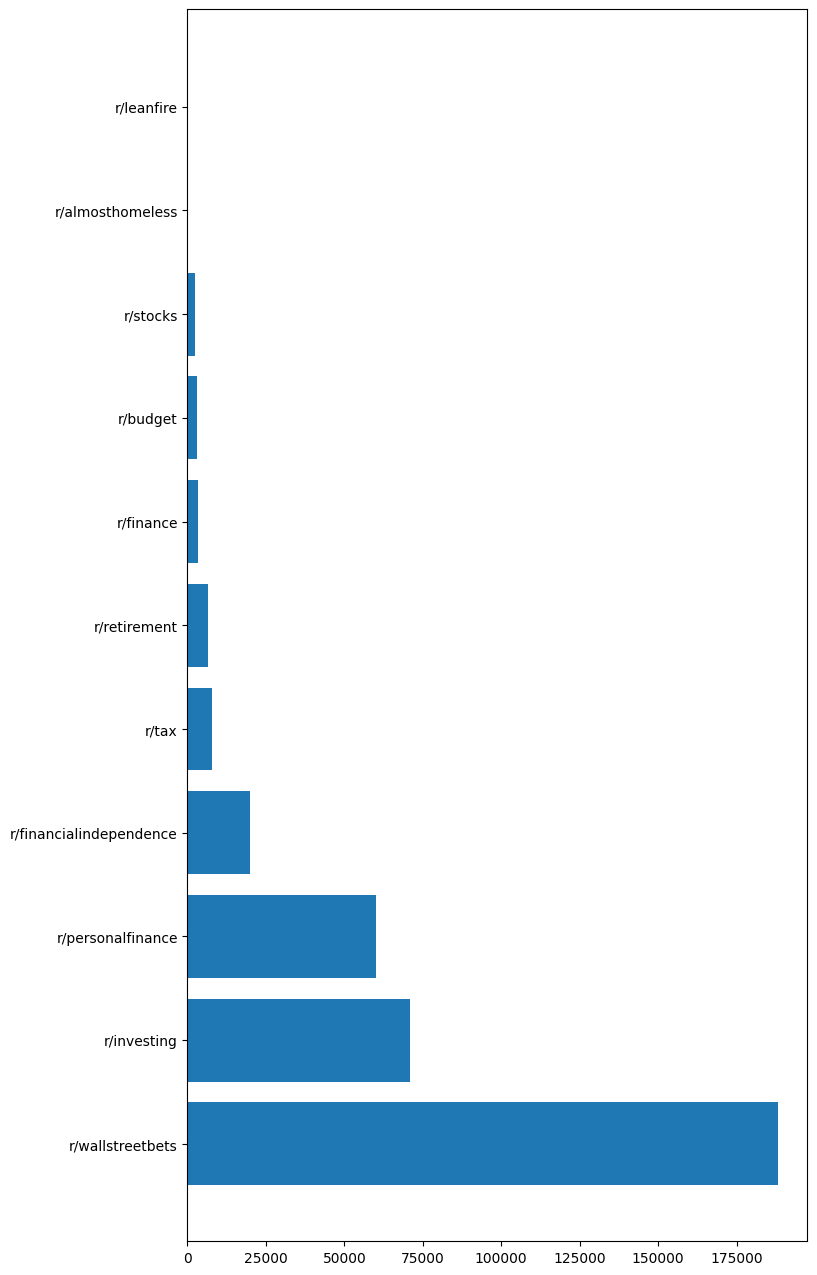

In [ ]:
label_count = dict(df.label.value_counts())
plt.figure(figsize=(8, 16))
plt.barh(range(len(label_count)), label_count.values())
plt.yticks(range(len(label_count)), label_count.keys())
plt.show()

The length of text objects (in total characters) follows the following distribution:

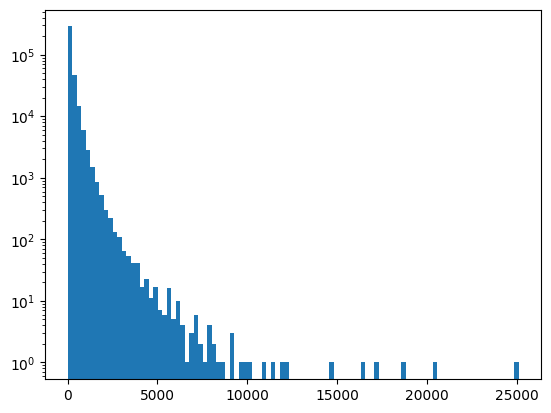

In [ ]:
plt.hist(df.text.str.len(), bins=100, log=True)
plt.show()

The average length of text objects (in space-separated words) is:

In [ ]:
print(df.text.str.split().apply(len).mean())

34.72817278751061


The length of text objects (in space-separated words) follows the following distribution:

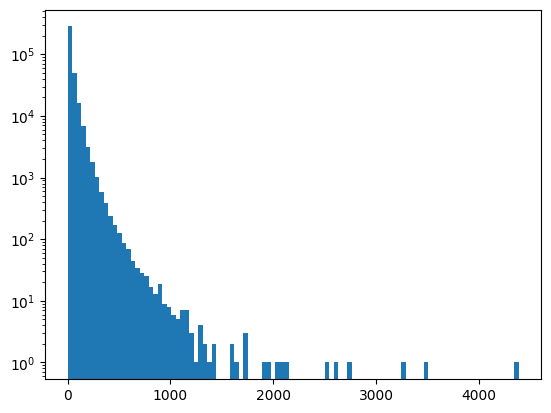

In [ ]:
plt.hist(df.text.str.split().apply(len), bins=100, log=True)
plt.show()

Now let's see which subreddits have the longest messages on average in terms of characters:

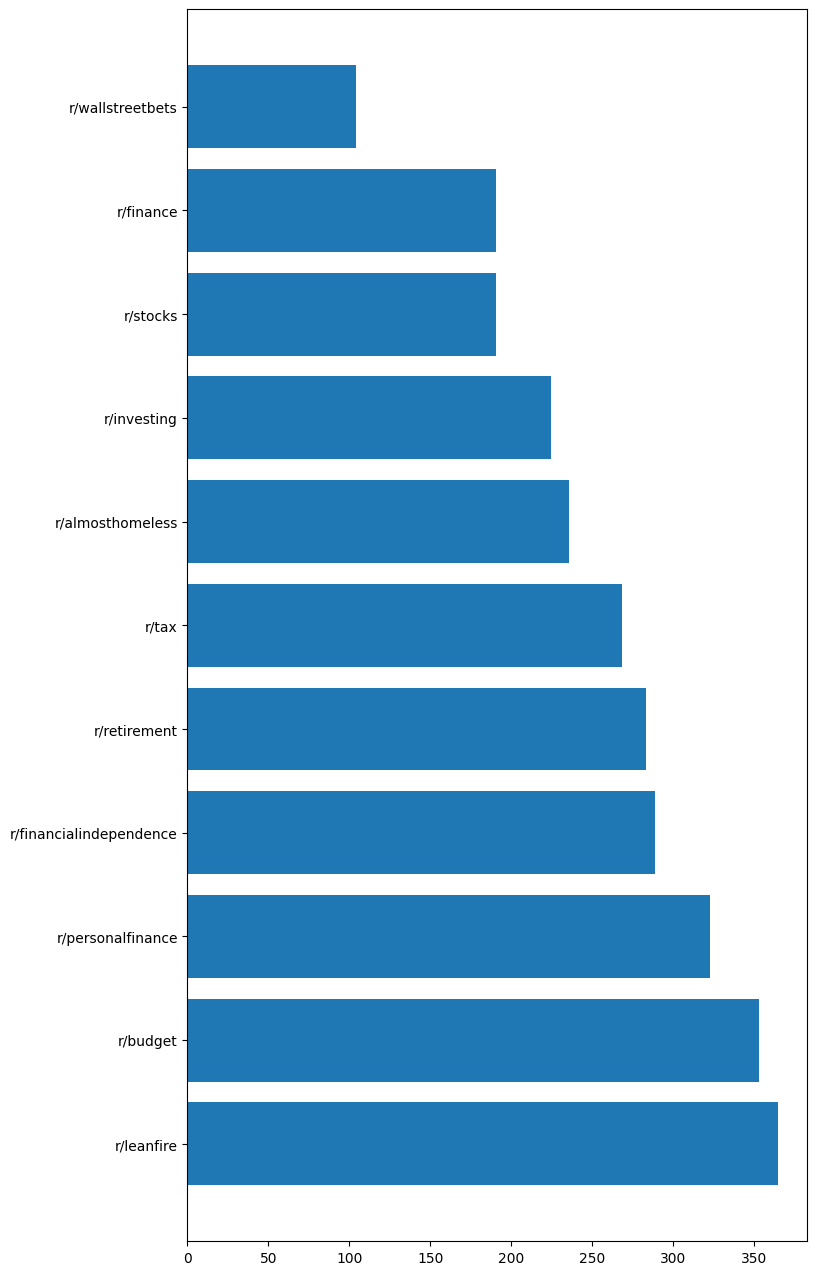

In [ ]:
avg_len_by_subreddit = df.groupby('label').text.apply(lambda x: x.str.len().mean())
avg_len_by_subreddit = avg_len_by_subreddit.sort_values(ascending=False)
plt.figure(figsize=(8, 16))
plt.barh(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.values)
plt.yticks(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.keys())
plt.show()

And in terms of words:

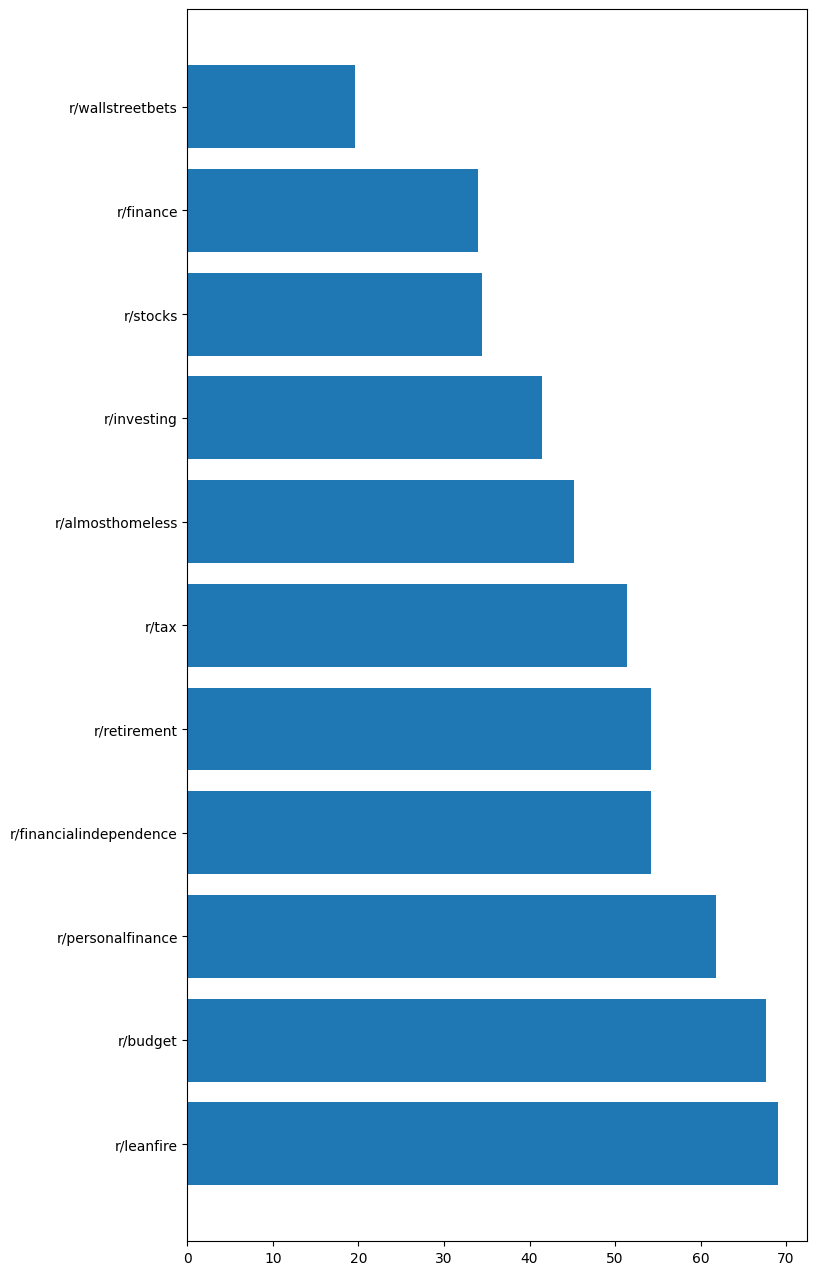

In [ ]:
avg_len_by_subreddit = df.groupby('label').text.apply(lambda x: x.str.split().apply(len).mean())
avg_len_by_subreddit = avg_len_by_subreddit.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 16))
plt.barh(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.values)
plt.yticks(range(len(avg_len_by_subreddit)), avg_len_by_subreddit.keys())
plt.show()

The same!

One last thing we can do is check the posts-to-comments ratios.

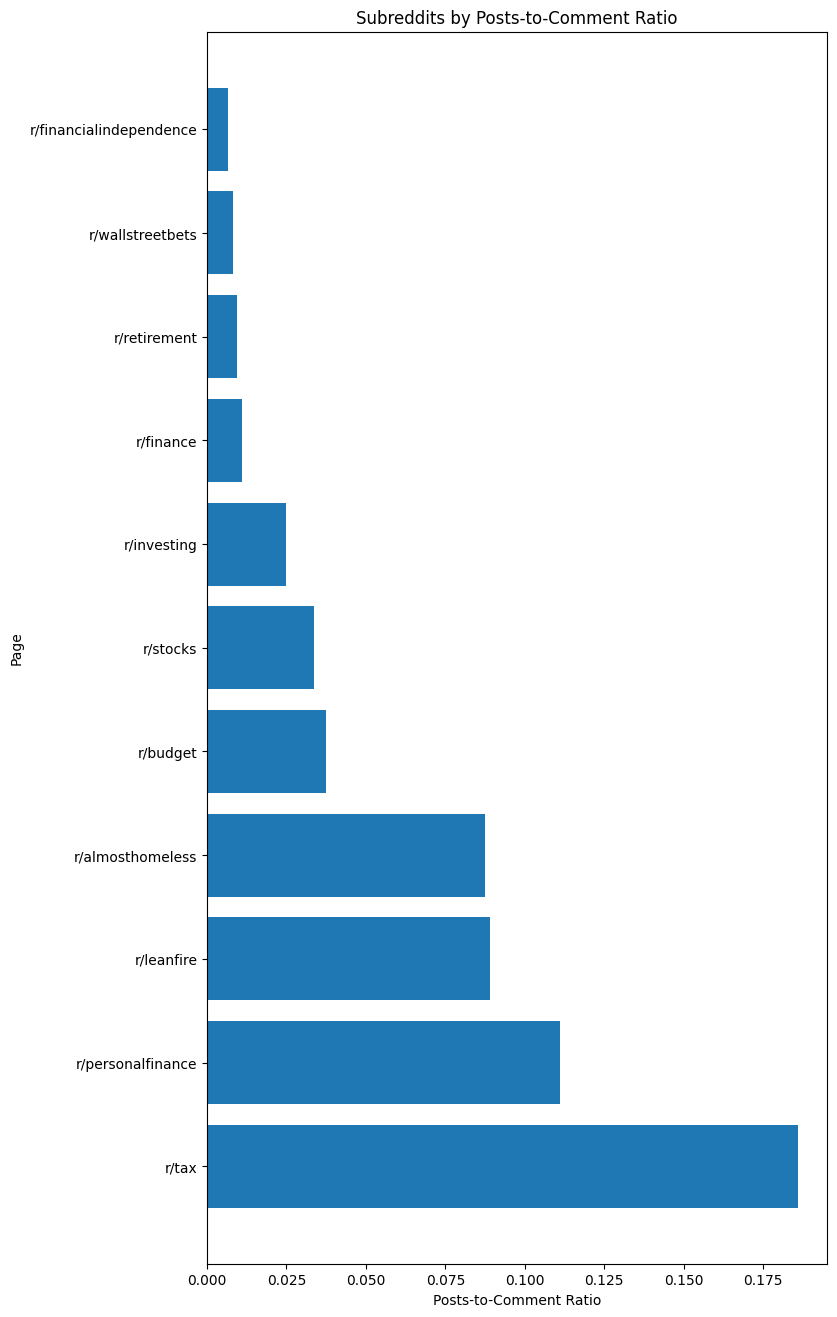

In [ ]:
posts_comments_ratio = df.groupby('label').dataType.value_counts(normalize=True)
posts_comments_ratio = posts_comments_ratio.unstack()
posts_comments_ratio = posts_comments_ratio['post'] / posts_comments_ratio['comment']
posts_comments_ratio = posts_comments_ratio.sort_values(ascending=False)
plt.figure(figsize=(8, 16))
plt.barh(range(len(posts_comments_ratio)), posts_comments_ratio.values)
plt.yticks(range(len(posts_comments_ratio)), posts_comments_ratio.keys())
plt.xlabel("Posts-to-Comment Ratio")
plt.ylabel("Page")
plt.title("Subreddits by Posts-to-Comment Ratio")
plt.show()

Now the opposite:

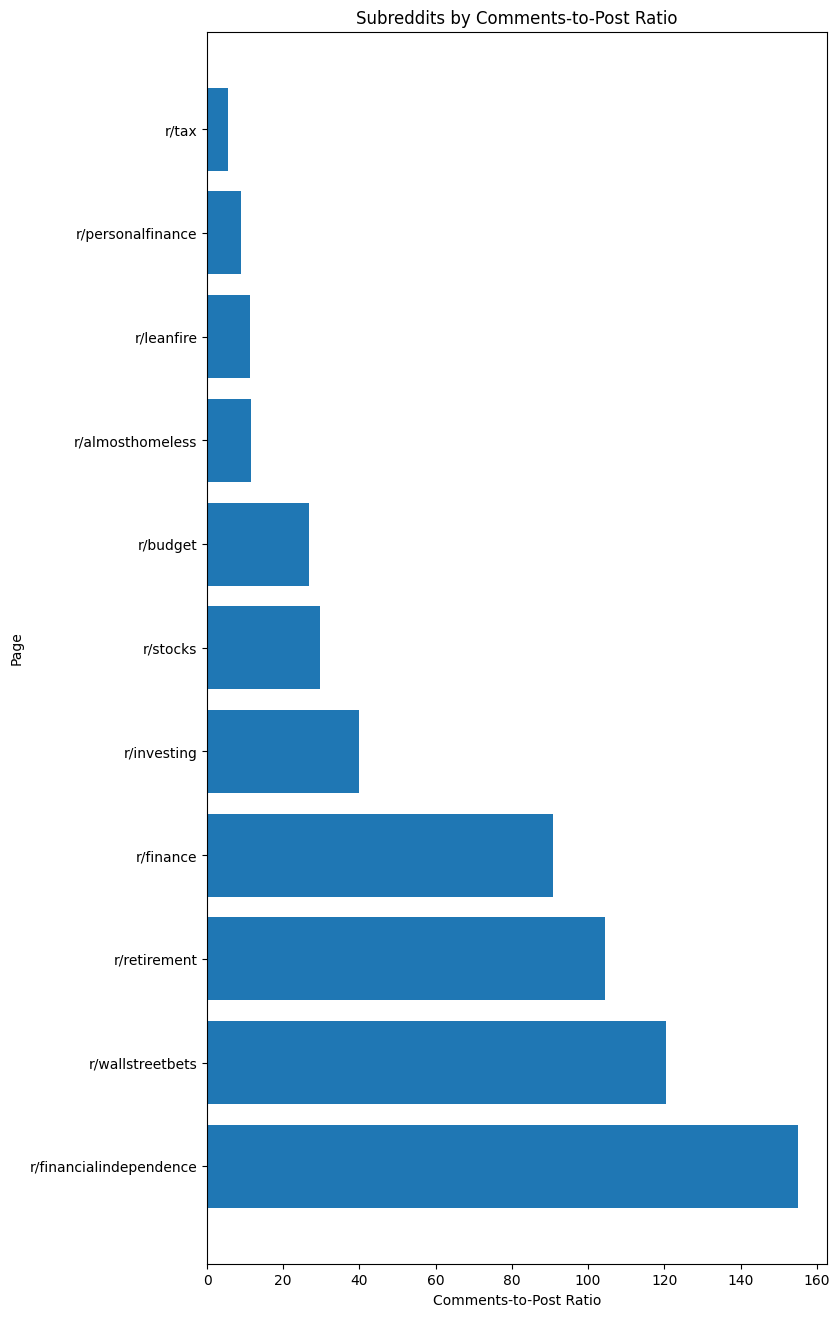

In [ ]:
comments_posts_ratio = df.groupby('label').dataType.value_counts(normalize=True)
comments_posts_ratio = comments_posts_ratio.unstack()
comments_posts_ratio = comments_posts_ratio['comment'] / comments_posts_ratio['post']
comments_posts_ratio = comments_posts_ratio.sort_values(ascending=False)
plt.figure(figsize=(8, 16))
plt.barh(range(len(comments_posts_ratio)), comments_posts_ratio.values)
plt.yticks(range(len(comments_posts_ratio)), comments_posts_ratio.keys())
plt.xlabel("Comments-to-Post Ratio")
plt.ylabel("Page")
plt.title("Subreddits by Comments-to-Post Ratio")
plt.show()

## Vocabulary analysis

In [ ]:
corpus = list(df.text)
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

CountVectorizer()

The total length of the vocabulary is:

In [ ]:
vocab_length = len(vectorizer.get_feature_names_out())
vocab_length

150104

And on average per document:

In [ ]:
vector_documents = vectorizer.transform(corpus)
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]
nonzero_count/doc_count

25.88457128366832

Let's have a look at some examples:

In [ ]:
samples = random.sample(list(vectorizer.get_feature_names_out()), 30)
print(samples)

['subjective', 'dude', 'creaks', 'emergencytrade', 'hm', 'aroused', 'goodwhen', 'aprk', 'kicking', 'easyjet', 'horizonnot', 'graphictheres', 'futuresthe', 'fluidity', 'perestroika', 'rudest', 'ringing', 'googamzng', 'totaledtotaled', 'looksbut', 'deferment', 'putsand', 'retruths', 'focusnew', 'yeahthats', 'switzerlandit', 'bbai', 'thanksgivin', 'ssglx', 'campaignin']


Let's only consider terms that appear in at least 2 documents, to remove some obscure terms/typos that passed through our cleaning.

In [ ]:
vectorizer = CountVectorizer(min_df=2)
vectorizer.fit(corpus)
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
samples = random.sample(list(vectorizer.get_feature_names_out()), 30)
print(samples)

Vocabulary size: 53239
['battered', 'noon', 'mta', 'hiya', 'chrysler', 'ignored', 'compulsively', 'oversimplifying', 'ussy', 'aaannd', 'freeloading', 'recoup', 'formulas', 'renting', 'comics', 'registrations', 'rewording', 'nasdaq', 'puppet', 'foryour', 'mestill', 'isk', 'lay', 'scami', 'pulverized', 'slippers', 'confused', 'unthinkable', 'carpark', 'messenger']


Much better! There are still a few suspicious terms, but they might just be some acronyms or slang that are not standard English but still relevant to our application.

The total length of the vocabulary is now:

In [ ]:
vocab_length = len(vectorizer.get_feature_names_out())
vocab_length

53239

That's much smaller!

And on average per document:

In [ ]:
vector_documents = vectorizer.transform(corpus)
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]
nonzero_count/doc_count

25.617581393810433